In [1]:
#Import Python Libraries
import pandas as pd
import pickle
import time
import numpy as np

#Import Self-written Functions
import os
import sys
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

from d00_utils.calculateTimeDifference import calculateTimeDifference #Function to calc time difference
from d01_data.loadCommits import loadCommits #Function to load SVN data
from d02_intermediate.cleanCommitData import cleanCommitData #Function to clean commit data
from d02_intermediate.cleanJiraData import cleanJiraData #Function to clean JIRA data

from d03_processing.createFittedTF_IDF import createFittedTF_IDF #Function to see if a trace is valid
from d03_processing.createCorpusFromDocumentList import createCorpusFromDocumentList #Function to create a corpus
from d03_processing.checkValidityTrace import checkValidityTrace #Function to see if a trace is valid
from d03_processing.calculateTimeDif import calculateTimeDif #Calculate the time difference between 2 dates in seconds
from d03_processing.checkFullnameEqualsEmail import checkFullnameEqualsEmail #Check if fullName is equal to the email
from d03_processing.calculateCosineSimilarity import calculateCosineSimilarity #Calculate the cos similarity
from d03_processing.calculateDocumentStatistics import calculateUniqueWordCount
from d03_processing.calculateDocumentStatistics import calculateTotalWordCount
from d03_processing.calculateDocumentStatistics import calculateOverlapBetweenDocuments

from d04_modelling.summariseClassDistribution import summariseClassDistribution #Visualize the class distribution
from d04_modelling.showModelPerformance import showModelPerformance # Show several performance measures

#Display full value of a column
pd.set_option('display.max_colwidth', None)

#Display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. Load Raw Data

In [2]:
#Set dataset

datasetDirectory = ""

In [3]:
#Import raw JIRA dataset
rawData_JIRA_dataProcessing = pd.read_csv('../data/01_raw/JIRA Mendix.csv')
rawData_JIRA_academy = pd.read_excel('../data/01_raw/JIRA Mendix Academy export.xlsx')
rawData_JIRA_academyMay = pd.read_excel('../data/01_raw/JIRA Mendix Academy export_15_05_2021.xlsx')

#import
rawData_SVN_dataProcessing = loadCommits("../data/01_raw/data-processing-svn-dump.txt")
rawData_SVN_academy= loadCommits("../data/01_raw/academy-svn-dump.txt")

# 2. Clean Raw Data
## 2.1 Clean Raw Data - SVN Data
Clean the raw data of the SVN files

In [27]:
from datetime import datetime
import re
import pandas as pd
import string

#nltk for NLP 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.util import ngrams

#Function to transform natural text into unigram tokens
def preprocessNaturalLanguage(text, porterStemmer, cachedStopWords):
    string_text = str(text)
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_interpunction)
    
    #remove stopwords
    tokens_without_sw = [word for word in tokens if not word in cachedStopWords]
    
    #Stem the tokens
    stemmedToken = list(map(porterStemmer.stem, tokens_without_sw))

    return(stemmedToken)

#Function to transform natural text into n-gram tokens
def preprocessNGrams(text, porterStemmer, cachedStopWords, nGramSize):
    string_text = str(text)
    
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_interpunction)
    
    #Create the ngrams
    ngrams = list(nltk.ngrams(tokens, nGramSize))
    
    #remove all the n-grams containing a stopword
    cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
    #Stem the tokens
    stemmedNGrams = []
    for ngram in cleanNGrams:
        stemmed = list(map(porterStemmer.stem, ngram))
        stemmedNGrams.append(stemmed)
    return(stemmedNGrams)

#Function to transform date into a date object
def preprocessCommitDate(date_string):
    date_time_obj = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S.%fZ')  
    return(date_time_obj)
    
#Remove the found Issue key from the log
def removeIssueKey(log_message):
    issue_keys = re.findall(r"LRN+.[0-9]+|AFM+.[0-9]+|MA+.[0-9]+", log_message)
    log_message_without_key = log_message
    for issue_key in issue_keys:
        log_message_without_key = log_message_without_key.replace(issue_key, "")
    return(log_message_without_key)

def unitNamesLambdaFunc(unitName, stemmer):
    #Lower case
    unitNameLowered = unitName.lower()
    
    #Remove interpunction
    noInterpunction = unitNameLowered.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    noNumbers = ''.join([i for i in noInterpunction if not i.isdigit()])
    
    stemmendUnitName = stemmer.stem(noInterpunction)
    
    
    return(stemmendUnitName)
    

def preprocessUnitNames(unitName, porterStemmer, cachedStopWords):
    if (isinstance(unitName, str)):
        #Split camelCasing
        #print(unitName)
        unitNameList = list(unitName.split(" "))
        #print(unitNameList)
        unitNameArray = np.array(unitNameList)
        uniqueUnitNames = np.unique(unitNameArray)


        uniqueUnitNamesString = ' '.join(uniqueUnitNames)
        unitNameSplitStringList = re.split('_| ', uniqueUnitNamesString)

        #unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', uniqueUnitNamesString)).split()
        
        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #Preprocess each split found.
        unitNameLowered = list(map(lambda unitName: unitNamesLambdaFunc(unitName, porterStemmer), 
                                   unitNameSplitStringList))
        
        #Check for stopwords
        tokensWithoutSW = [word for word in unitNameLowered if not word in cachedStopWords]

        return(unitNameLowered)

def preprocessNGramsUnitNames(unitName, porterStemmer, cachedStopWords, nGramSize):
    if (isinstance(unitName, str)):
        #Split camelCasing
        #print(unitName)
        unitNameList = list(unitName.split(" "))
        #print(unitNameList)
        unitNameArray = np.array(unitNameList)
        uniqueUnitNames = np.unique(unitNameArray)


        uniqueUnitNamesString = ' '.join(uniqueUnitNames)
        unitNameSplitStringList = re.split('_| ', uniqueUnitNamesString)
        #Split camelCasing
        unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', unitName)).split()
        
        cleanedUnitNames = []
        for unitNameSplit in unitNameSplitStringList:
            #Lower case unit names
            lowerCased = unitNameSplit.lower()

            #Remove interpunction
            removedInterpunction = lowerCased.translate(str.maketrans('','',string.punctuation))
            cleanedUnitNames.append(removedInterpunction)
            
        #Transform to string (needed for tokenizer
        unitNameString = ' '.join(cleanedUnitNames)

        #Tokenzize words
        tokenized = word_tokenize(unitNameString)
        
        #Create the ngrams
        ngrams = list(nltk.ngrams(tokenized, nGramSize))
        
        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #remove all the n-grams containing a stopword
        cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
        #Stem the tokens
        stemmedNGrams = []
        for ngram in cleanNGrams:
            stemmed = list(map(porterStemmer.stem, ngram))
            stemmedNGrams.append(stemmed)
            
        return(stemmedNGrams)

#Method to clean all columns of the provided data
def cleanCommitData(rawCommitData): 
    #create an object of class PorterStemmer
    porterStemmer = PorterStemmer()
    
    #Find all stopwords
    cachedStopWords = stopwords.words("english")
    
    #Remove all revisions without an issue key in the log message
    commit_df = rawCommitData[rawCommitData["related_issue_key"].notna()]

    #Execute cleaning methods on dataset
    cleaned_commit_logs = commit_df['log'].apply(lambda x: removeIssueKey(x))
    processed_commit_logs = cleaned_commit_logs.apply(lambda x: preprocessNaturalLanguage(x, porterStemmer, cachedStopWords))
    processed_commit_logs_2grams = cleaned_commit_logs.apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    processed_commit_logs_3grams = cleaned_commit_logs.apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 3))
    processed_date_times = commit_df['date'].apply(lambda x: preprocessCommitDate(x))
    processed_unit_names = commit_df['impacted_unit_names'].apply(lambda x: preprocessUnitNames(x, porterStemmer, cachedStopWords))
    processed_unit_names_2grams = commit_df['impacted_unit_names'].apply(lambda x: preprocessNGramsUnitNames(x, porterStemmer, cachedStopWords, 2))
    processed_unit_names_3grams = commit_df['impacted_unit_names'].apply(lambda x: preprocessNGramsUnitNames(x, porterStemmer, cachedStopWords, 3))
    

    #Put all data together into a new dataframe
    commit_data = {'Revision': commit_df["revision"],
               'Email' : commit_df["email"],
               'Commit_date': processed_date_times,
               "Issue_key_commit": commit_df["related_issue_key"],
               'Logs': processed_commit_logs, 
               'Logs_2grams': processed_commit_logs_2grams, 
               'Logs_3grams': processed_commit_logs_3grams, 
               'Unit_names': processed_unit_names,
               'Unit_names_2grams': processed_unit_names_2grams,
               'Unit_names_3grams': processed_unit_names_3grams,
               'Commit_natural_text': processed_commit_logs + processed_unit_names,
               'Commit_natural_text_2grams': processed_commit_logs_2grams + processed_unit_names_2grams,
               'Commit_natural_text_3grams': processed_commit_logs_3grams + processed_unit_names_3grams
               }
               
    commit_processed_df = pd.DataFrame(data=commit_data)

    return(commit_processed_df)

In [28]:
#Start timer
startTime = time.time() 

intermediateData_SVN_dataProcessing = cleanCommitData(rawData_SVN_dataProcessing)
intermediateData_SVN_academy = cleanCommitData(rawData_SVN_academy)

#Create a temp XLSX file for all intermediate datasets
intermediateData_SVN_dataProcessing.to_excel(excel_writer = "../data/02_intermediate/intermediateData_SVN_dataProcessing.xlsx", index = False)
intermediateData_SVN_academy.to_excel(excel_writer = "../data/02_intermediate/intermediateData_SVN_academy.xlsx", index = False)

#Create a pickle file for all intermediate datasets
intermediateData_SVN_dataProcessing.to_pickle(path= "../data/02_intermediate/intermediateData_SVN_dataProcessing.pkl")
intermediateData_SVN_academy.to_pickle(path= "../data/02_intermediate/intermediateData_SVN_academy.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished cleaning after " + timeDifference)

Finished cleaning after 0 minutes and 11.07300066947937 seconds


In [29]:
import re

import string
#nltk for NLP 
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag  import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from datetime import datetime
import numpy as np
import pandas as pd
import time
nltk.download('averaged_perceptron_tagger')


#Function to clean the comments
def clean_comments(comment):
    try:
        commentDates = re.findall(r"[0-9]{2} [A-Z][a-z]{2} [0-9]{4} [0-9]{2}:[0-9]{2};[a-zA-Z0-9_]{24};", comment)
        accountIds = re.findall(r"\[~accountid:[a-zA-Z0-9]{24}\]", comment)
               
        
        cleanedComment = comment.replace("nan",'')
        for commentDate in commentDates:
            cleanedComment = cleanedComment.replace(commentDate,'')
        
        for accountId in accountIds: 
            cleanedComment = cleanedComment.replace(accountId,'')
        
        return(cleanedComment)
    except:
        return("")

def preprocess(text, porterStemmer, cachedStopwords):
    string_text = str(text)
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #remove stopwords
    tokens_without_sw = [word for word in tokens if not word in cachedStopwords]
    
    #Stem the tokens
    stemmedToken = list(map(porterStemmer.stem, tokens_without_sw))

    return(stemmedToken)

def preprocessNGrams(text, porterStemmer, cachedStopWords, nGramSize):
    string_text = str(text)
    
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #Create the ngrams
    ngrams = list(nltk.ngrams(tokens, nGramSize))
    
    #remove all the n-grams containing a stopword
    cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
    #Stem the tokens
    stemmedNGrams = []
    for ngram in cleanNGrams:
        stemmed = list(map(porterStemmer.stem, ngram))
        stemmedNGrams.append(stemmed)
    return(stemmedNGrams)

#Function to transform date into a date object
def preprocess_jira_date(date_string):
    if(isinstance(date_string, str)):
        try:
            date_time_obj = datetime.strptime(date_string, '%d %b %Y %H:%M')
        except:
            date_time_obj = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S:%f')
        return(date_time_obj)
    elif(isinstance(date_string, datetime)): 
        return(date_string)
    else:
        return(np.nan)
    
    
def findVerbs(tokenList):
    posTags = pos_tag(tokenList)
    verbAbrList = ['VBP', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS']
    verbList = []
    for posTag in posTags:
        if posTag[1] in verbAbrList:
            verbList.append(posTag[0])
    return(verbList)

#Preprocess all the features and transform to the format needed for further processing.
def preprocessJiraData(cleanDataFrame, preprocessComments, porterStemmer, cachedStopWords, startTime):
    if (preprocessComments == True):
        nOfSteps = '4'
    else:
        nOfSteps = '3'

    #preprocess Summaries
    jira_summaries = cleanDataFrame['Summary'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
    jira_summaries_2grams = cleanDataFrame['Summary'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    jira_summaries_3grams = cleanDataFrame['Summary'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 3))
    
    endTimeCleaningSummaries = time.time() - startTime
    print("1/" + nOfSteps + ") Finished Cleaning Summaries after " + str(endTimeCleaningSummaries) + " sec")

    #preprocess Descriptions
    jira_descriptions = cleanDataFrame['Description'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
    jira_descriptions_2grams = cleanDataFrame['Description'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    jira_descriptions_3grams = cleanDataFrame['Description'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    
    endTimeCleaningDescriptions = time.time() - startTime
    print("2/" + nOfSteps + ") Finished Cleaning Description after " + str(endTimeCleaningDescriptions) + " sec")

    #preprocess Dates
    jira_creation = cleanDataFrame['Created'].apply(lambda x: preprocess_jira_date(x))
    jira_updated = cleanDataFrame['Updated'].apply(lambda x: preprocess_jira_date(x))
    jira_resolved = cleanDataFrame['Resolved'].apply(lambda x: preprocess_jira_date(x))
    endTimeCleaningDates = time.time() - startTime
    print("3/" + nOfSteps + ") Finished Cleaning Dates after " + str(endTimeCleaningDates) + " sec")

    #Comments take too long for a test run.
    if (preprocessComments == True):
        jira_comments = cleanDataFrame['Comments'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
        jira_comments_2grams = cleanDataFrame['Comments'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
        jira_comments_3grams = cleanDataFrame['Comments'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
        endTimeCleaningComments = time.time() - startTime
        print("4/" + nOfSteps + ") Finished Cleaning Comments after " + str(endTimeCleaningComments) + " sec")

         #create JIRA corpus by merging Summary and Description
        jira_data = {'Issue_key_jira': cleanDataFrame['Issue key'], 
             'Assignee': cleanDataFrame['Assignee'],
             'Jira_created_date': jira_creation, 
             'Jira_updated_date': jira_updated, 
             'Jira_resolved_date': jira_resolved, 
             'Summary': jira_summaries, 
             'Summary_2grams': jira_summaries_2grams,
             'Summary_3grams': jira_summaries_3grams, 
             'Description': jira_descriptions,
             'Description_2grams': jira_descriptions_2grams,
             'Description_3grams': jira_descriptions_3grams,
             'Comments': jira_comments,
             'Comments_2grams': jira_comments_2grams,
             'Comments_3grams': jira_comments_3grams,
             'Jira_natural_text': jira_summaries +  jira_descriptions + jira_comments,
             'Jira_natural_text_2grams': jira_summaries_2grams +  jira_descriptions_2grams + jira_comments_2grams,
             'Jira_natural_text_3grams': jira_summaries_3grams +  jira_descriptions_3grams + jira_comments_3grams}
    else:
         #create JIRA corpus by merging Summary and Description
        jira_data = {'Issue_key_jira': cleanDataFrame['Issue key'], 
             'Assignee': cleanDataFrame['Assignee'],
             'Jira_created_date': jira_creation, 
             'Jira_updated_date': jira_updated, 
             'Jira_resolved_date': jira_resolved, 
             'Summary': jira_summaries,
             'Summary_2grams': jira_summaries_2grams,
             'Summary_3grams': jira_summaries_3grams,
             'Description': jira_descriptions,
             'Description_2grams': jira_descriptions_2grams,
             'Description_3grams': jira_descriptions_3grams,
             'Jira_natural_text': jira_summaries +  jira_descriptions,
             'Jira_natural_text_2grams': jira_summaries_2grams +  jira_descriptions_2grams,
             'Jira_natural_text_3grams': jira_summaries_3grams +  jira_descriptions_3grams}

    jira_processed_df = pd.DataFrame(data=jira_data)
    
    #Find verbs
    jira_processed_df['verbs'] = jira_processed_df['Jira_natural_text'].apply(lambda x: findVerbs(x))
    
    return(jira_processed_df)

#Input dataframe and num of_comments, and bool to determine if comments need to be cleaned
def cleanJiraData(dataFrame, cleanComments, commentAmount):
    startTime = time.time()

    #create an object of class PorterStemmer
    porterStemmer = PorterStemmer()
    
    #Find all stopwords
    cachedStopWords = stopwords.words("english")

    if (cleanComments == True):
        #Subset only all comments 
        loc_first_comment = dataFrame.columns.get_loc('Comment') # Variable storing the col location of the 1st comment
    
        dataFrame["Comments"] = dataFrame.iloc[:,loc_first_comment:loc_first_comment+commentAmount].apply(
            lambda x: " ".join(x.astype(str)), axis=1)
    
        #First remove the date and comment string from the comments
        dataFrame["Comments"] = dataFrame["Comments"].apply(lambda x: clean_comments(x))

        #Subset JIRA ID, Summary, Description, comments
        jira_issues_subset = dataFrame[["Issue key", "Assignee", "Summary", "Description", "Comments", "Created", "Resolved", "Updated"]]
        cleanedAndProcessedJiraData = preprocessJiraData(jira_issues_subset, preprocessComments = True, porterStemmer = porterStemmer, cachedStopWords = cachedStopWords, startTime = startTime)
        return(cleanedAndProcessedJiraData)
    else: 
        jira_issues_subset = dataFrame[["Issue key", "Assignee", "Summary", "Description", "Created", "Resolved", "Updated"]]
        cleanedAndProcessedJiraData = preprocessJiraData(jira_issues_subset, preprocessComments = False, porterStemmer = porterStemmer, cachedStopWords = cachedStopWords, startTime = startTime)
        return(cleanedAndProcessedJiraData)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rande\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [30]:
#Rename key to Issue key
rawData_JIRA_academyMay = rawData_JIRA_academyMay.rename({'Key': 'Issue key'}, axis=1)

#Clean Data sets
intermediateData_JIRA_dataProcessing = cleanJiraData(dataFrame = rawData_JIRA_dataProcessing, cleanComments = False, commentAmount = 39)
intermediateData_JIRA_academyMay = cleanJiraData(dataFrame = rawData_JIRA_academyMay, cleanComments = False, commentAmount = 0)

#Create a temp XLSX file for all intermediate datasets
intermediateData_JIRA_dataProcessing.to_excel(excel_writer = "../data/02_intermediate/intermediateData_JIRA_dataProcessing.xlsx", index = False)
intermediateData_JIRA_academyMay.to_excel(excel_writer = "../data/02_intermediate/intermediateData_JIRA_academyMay.xlsx", index = False)

#Create a pickle file for all intermediate datasets
intermediateData_JIRA_dataProcessing.to_pickle(path= "../data/02_intermediate/intermediateData_JIRA_dataProcessing.pkl")
intermediateData_JIRA_academyMay.to_pickle(path= "../data/02_intermediate/intermediateData_JIRA_academyMay.pkl")

1/3) Finished Cleaning Summaries after 0.054303646087646484 sec
2/3) Finished Cleaning Description after 0.2866494655609131 sec
3/3) Finished Cleaning Dates after 0.2886486053466797 sec
1/3) Finished Cleaning Summaries after 0.6934523582458496 sec
2/3) Finished Cleaning Description after 6.887400150299072 sec
3/3) Finished Cleaning Dates after 6.89537787437439 sec


## 2.4 Clean Raw Data - Create JIRA Corpora
Create the corpora for JIRA UNIGRAM

In [31]:
def createCorpusFromDocumentList(token_column):
    token_list = token_column.tolist()
    corpus_list = []
    
    for document in token_list:
        #Only join to the string when a list. When it is not a list, then it is np.NaN, thus no changes
        if(isinstance(document, list)):
            #Transform list to a string for SKLEARN to accept the input.
            token_string = ' '.join(document)
        
            #Add string to the corpus list
            corpus_list.append(token_string)
    return(corpus_list)

In [32]:
#Create JIRA corpus for dataProcessing dataset
intermediateData_JIRA_dataProcessingCorpusSummary = createCorpusFromDocumentList(intermediateData_JIRA_dataProcessing.Summary)
intermediateData_JIRA_dataProcessingCorpusDescription = createCorpusFromDocumentList(intermediateData_JIRA_dataProcessing.Description)
#intermediateData_JIRA_dataProcessingCorpusComments = createCorpusFromDocumentList(intermediateData_JIRA_dataProcessing.Comments)

#Create JIRA corpus for academy dataset
intermediateData_JIRA_academyMayCorpusSummary = createCorpusFromDocumentList(intermediateData_JIRA_academyMay.Summary)
intermediateData_JIRA_academyMayCorpusDescription = createCorpusFromDocumentList(intermediateData_JIRA_academyMay.Description)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_dataProcessingCorpus = [i+" "+j for i,j in zip(intermediateData_JIRA_dataProcessingCorpusSummary,
                                                                             intermediateData_JIRA_dataProcessingCorpusDescription,
                                                                             #intermediateData_JIRA_dataProcessingCorpusComments
                                                                            )]

intermediateData_JIRA_academyMayCorpus = [i+" "+j for i,j in zip(intermediateData_JIRA_academyMayCorpusSummary,
                                                                 intermediateData_JIRA_academyMayCorpusDescription)]


#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_dataProcessingCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_dataProcessingCorpus, f)
with open('../data/02_intermediate/intermediateData_JIRA_academyMayCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_academyMayCorpus, f)

Bigram corpora

In [33]:
def createCorpusNGrams(tokenColumn):
    tokenList = tokenColumn.tolist()
    corpusList = []
    
    #Transform to strings
    for document in tokenList:
        if(isinstance(document, list)):
            for ngram in document:
                ngramString = ' '.join(ngram)
                corpusList.append(ngramString)         
    return(corpusList)

In [34]:
#Create JIRA corpus for dataProcessing dataset
intermediateData_JIRA_dataProcessingCorpusSummary_2grams = createCorpusNGrams(intermediateData_JIRA_dataProcessing.Summary_2grams)
intermediateData_JIRA_dataProcessingCorpusDescription_2grams = createCorpusNGrams(intermediateData_JIRA_dataProcessing.Description_2grams)
#intermediateData_JIRA_dataProcessingCorpusComments_2grams = createCorpusNGrams(intermediateData_JIRA_dataProcessing.Comments_2grams)

#Create JIRA corpus for academy dataset
#intermediateData_JIRA_academyMayCorpusSummary = createCorpusFromDocumentList(intermediateData_JIRA_academyMay.Summary)
#intermediateData_JIRA_academyMayCorpusDescription = createCorpusFromDocumentList(intermediateData_JIRA_academyMay.Description)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_dataProcessingCorpus_2gram = [i+" "+j for i,j in zip(intermediateData_JIRA_dataProcessingCorpusSummary_2grams,
                                                                             intermediateData_JIRA_dataProcessingCorpusDescription_2grams,
                                                                             #intermediateData_JIRA_dataProcessingCorpusComments_2grams
                                                                                  )]

#intermediateData_JIRA_academyMayCorpus = [i+" "+j for i,j in zip(intermediateData_JIRA_academyMayCorpusSummary,
#                                                                 intermediateData_JIRA_academyMayCorpusDescription)]


#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_dataProcessingCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_dataProcessingCorpus_2gram, f)
#with open('../data/02_intermediate/intermediateData_JIRA_academyMayCorpus.pkl', 'wb') as f:
#    pickle.dump(intermediateData_JIRA_academyMayCorpus, f)

## 2.4 Clean Raw Data - Create SVN Corpora
Create the corpora for SVN

In [35]:
intermediateData_SVN_dataProcessing = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_dataProcessing.pkl")

In [36]:
#Create corpus for log messages
intermediateData_SVNLogs_dataProcessingCorpus = createCorpusFromDocumentList(intermediateData_SVN_dataProcessing.Logs)
intermediateData_SVNLogs_academyCorpus = createCorpusFromDocumentList(intermediateData_SVN_academy.Logs)
intermediateData_SVNLogs_academyCorpus = createCorpusFromDocumentList(intermediateData_SVN_academy.Logs)

#Create corpus for unit names
intermediateData_SVNUnitNames_dataProcessingCorpus = createCorpusFromDocumentList(intermediateData_SVN_dataProcessing.Unit_names)
intermediateData_SVNUnitNames_academyCorpus = createCorpusFromDocumentList(intermediateData_SVN_academy.Unit_names)

#Create corpus for entire commit (log message + model)
intermediateData_SVN_dataProcessingCorpusAll = createCorpusFromDocumentList(intermediateData_SVN_dataProcessing.Logs + intermediateData_SVN_dataProcessing.Unit_names)

#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_SVNLogs_dataProcessingCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNLogs_dataProcessingCorpus, f)
with open('../data/02_intermediate/intermediateData_SVNLogs_academyCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNLogs_academyCorpus, f)
with open('../data/02_intermediate/intermediateData_SVNUnitNames_dataProcessingCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNUnitNames_dataProcessingCorpus, f)
with open('../data/02_intermediate/intermediateData_SVNUnitNames_academyCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNUnitNames_academyCorpus, f)
with open('../data/02_intermediate/intermediateData_SVN_dataProcessingCorpusAll.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_dataProcessingCorpusAll, f)

bigram corpora

In [37]:
intermediateData_SVNLogs_dataProcessingCorpus_2gram = createCorpusNGrams(intermediateData_SVN_dataProcessing.Logs_2grams)
intermediateData_SVNUnitNames_dataProcessingCorpus_2gram = createCorpusNGrams(intermediateData_SVN_dataProcessing.Unit_names_2grams)
with open('../data/02_intermediate/intermediateData_SVNLogs_dataProcessingCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNLogs_dataProcessingCorpus_2gram, f)
    
    
with open('../data/02_intermediate/intermediateData_SVNUnitNames_dataProcessingCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNUnitNames_dataProcessingCorpus_2gram, f)

In [38]:
print(intermediateData_SVNUnitNames_dataProcessingCorpus_2gram)

['act datacategori', 'datacategori save', 'save act', 'act datacontrol', 'datacontrol save', 'save act', 'act datasubject', 'datasubject save', 'save act', 'act processingactivitywizard', 'processingactivitywizard step1', 'step1 step2', 'step2 act', 'act processorsafeguard', 'processorsafeguard save', 'save act', 'act region', 'region save', 'save bco', 'bco securitymeasur', 'securitymeasur save', 'save datacategori', 'datacategori newedit', 'newedit datacontrol', 'datacontrol newedit', 'newedit datasubject', 'datasubject newedit', 'newedit depart', 'depart region', 'region set', 'set processorsafeguard', 'processorsafeguard newedit', 'newedit region', 'region newedit', 'newedit sub', 'sub valid', 'valid step1', 'act datacategori', 'datacategori save', 'save act', 'act datacontrol', 'datacontrol save', 'save act', 'act datasubject', 'datasubject save', 'save act', 'act gotostepx', 'gotostepx invaliddata', 'invaliddata act', 'act newstep', 'newstep cancel', 'cancel act', 'act processing

# 3. Preprocess Data

In [39]:
#Run this code block when you've restarted the kernel, and want to use previously gained results.
intermediateData_JIRA_dataProcessing = pd.read_pickle("../data/02_intermediate/intermediateData_JIRA_dataProcessing.pkl")
intermediateData_JIRA_academyMay = pd.read_pickle("../data/02_intermediate/intermediateData_JIRA_academyMay.pkl")

intermediateData_SVN_dataProcessing = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_dataProcessing.pkl")
intermediateData_SVN_academy = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_academy.pkl")



intermediateData_JIRA_dataProcessingCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_JIRA_dataProcessingCorpus.pkl')
intermediateData_JIRA_academyMayCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_JIRA_academyMayCorpus.pkl')

intermediateData_SVN_dataProcessingCorpusAll = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_dataProcessingCorpusAll.pkl')
intermediateData_SVN_dataProcessingCorpusModel = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_dataProcessingCorpusModel.pkl')
intermediateData_SVN_dataProcessingCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_dataProcessingCorpus.pkl')
intermediateData_SVN_academyCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_academyCorpus.pkl')

############# Bigrams


############# Trigrams

## 3.0 Preprocess Data - Create cartesian product JIRA x Commits

In [40]:
#Create cartesian products JIRA x Commits
processedData_dataProcessingCartesian = intermediateData_JIRA_dataProcessing.merge(intermediateData_SVN_dataProcessing, how='cross')
processedData_academyCartesian = intermediateData_JIRA_academyMay.merge(intermediateData_SVN_academy, how='cross')

#Create a pickle file for all intermediate datasets
processedData_dataProcessingCartesian.to_pickle(path= "../data/03_processed/processedData_dataProcessingCartesian.pkl")
processedData_academyCartesian.to_pickle(path= "../data/03_processed/processedData_academyCartesian.pkl")

## 3.1 Preprocess Data - Create Labels

In [41]:
#Create new dataFrames for the time features
processedData_dataProcessingLabels = pd.DataFrame() 
processedData_academyLabels = pd.DataFrame() 

#Create a column, which indicates which traces are valid.
processedData_dataProcessingLabels["is_valid"] = processedData_dataProcessingCartesian.apply(lambda x: checkValidityTrace(x.Issue_key_jira, x.Issue_key_commit), axis=1)
print("Finished creating labels for dataProcessing")
processedData_academyLabels["is_valid"] = processedData_academyCartesian.apply(lambda x: checkValidityTrace(x.Issue_key_jira, x.Issue_key_commit), axis=1)
print("Finished creating labels for academy")

#Save intermediate results
processedData_dataProcessingLabels.to_pickle(path= "../data/03_processed/processedData_dataProcessingLabels.pkl")
processedData_academyLabels.to_pickle(path= "../data/03_processed/processedData_academyLabels.pkl")

processedData_dataProcessingLabels.head(10)

Finished creating labels for dataProcessing
Finished creating labels for academy


,is_valid
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,False
8,False
9,False


## 3.2 Preprocess Data - Create Time-Related Features

In [ ]:
#Create new dataFrames for the time features
processedData_dataProcessingFeaturesTime = pd.DataFrame() 
processedData_academyFeaturesTime = pd.DataFrame() 

#Calculate the time features for data Processing Dataset
processedData_dataProcessingFeaturesTime['Creation_commit_date_dif'] = processedData_dataProcessingCartesian.apply(lambda x: calculateTimeDif(x.Jira_created_date, x.Commit_date), axis=1)
processedData_dataProcessingFeaturesTime['Updated_commit_date_dif'] = processedData_dataProcessingCartesian.apply(lambda x: calculateTimeDif(x.Jira_updated_date, x.Commit_date), axis=1)
processedData_dataProcessingFeaturesTime['Resolved_commit_date_dif'] = processedData_dataProcessingCartesian.apply(lambda x: calculateTimeDif(x.Jira_resolved_date, x.Commit_date), axis=1)
print("Finished data Processing")


#Calculate the time features for academy Dataset
processedData_academyFeaturesTime['Creation_commit_date_dif'] = processedData_academyCartesian.apply(lambda x: calculateTimeDif(x.Jira_created_date, x.Commit_date), axis=1)
processedData_academyFeaturesTime['Updated_commit_date_dif'] = processedData_academyCartesian.apply(lambda x: calculateTimeDif(x.Jira_updated_date, x.Commit_date), axis=1)
processedData_academyFeaturesTime['Resolved_commit_date_dif'] = processedData_academyCartesian.apply(lambda x: calculateTimeDif(x.Jira_resolved_date, x.Commit_date), axis=1)
print("Finished academy")

#Create a pickle file for all intermediate datasets
processedData_dataProcessingFeaturesTime.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesTime.pkl")
processedData_academyFeaturesTime.to_pickle(path= "../data/03_processed/processedData_academyFeaturesTime.pkl")

## 3.3 Preprocess Data - Create Stakeholder-Related Features

In [ ]:
#Create new dataFrames for the Stakeholder features
processedData_dataProcessingFeaturesStakeholder = pd.DataFrame() 
processedData_academyFeaturesStakeholder = pd.DataFrame() 

processedData_dataProcessingFeaturesStakeholder['Assignee_is_commiter'] = processedData_dataProcessingCartesian.apply(lambda x: checkFullnameEqualsEmail(x.Assignee, x.Email), axis=1)
print("Finished dataProcessing")
processedData_academyFeaturesStakeholder['Assignee_is_commiter'] = processedData_academyCartesian.apply(lambda x: checkFullnameEqualsEmail(x.Assignee, x.Email), axis=1)
print("Finished academy")

#Create a pickle file for all intermediate datasets
processedData_dataProcessingFeaturesStakeholder.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesStakeholder.pkl")
processedData_academyFeaturesStakeholder.to_pickle(path= "../data/03_processed/processedData_academyFeaturesStakeholder.pkl")

## 3.4 Preprocess Data - Create Cosine Similarity Features
### 3.4.1 DataProcessing - Cosine Similarity UniGrams

In [42]:
from scipy import spatial
import pandas as pd

def calc_vector_representation(document, cv, fittedTF_IDF):        
    #Transform document type to a string
    documentString = document
    
    #Calculate the Term Frequency of the document
    inputDocs = [documentString] 

    # count matrix 
    count_vector = cv.transform(inputDocs) 
 
    #tf-idf scores 
    tf_idf_vector = fittedTF_IDF.transform(count_vector)

    feature_names = cv.get_feature_names() 
 
    #get tfidf vector for first document 
    document_vector=tf_idf_vector[0] 
 
    #print the scores 
    
    # place tf-idf values in a pandas data frame 
    df = pd.DataFrame(document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
    df.sort_values(by=["tfidf"],ascending=False)

    return(document_vector.T.todense())

def calculateCosineSimilarity(document1, document2, cv, fittedTF_IDF):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    return(result)


def calculateCosineSimilarityWithPOSPruning(document1, document2, cv, fittedTF_IDF, verbList):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    verbCounter = 0
    if(isinstance(document2, list)):
        for token in document2:
            if token in verbList:
                verbCounter = verbCounter + 1
    
    if verbCounter > 0:
        result = result * (1 + (0.1 * verbCounter))
    else:
        result = 0
    
    return(result)

In [43]:
#Instantiate the count vectorizer and tfidf for the corpus
from sklearn.feature_extraction.text import CountVectorizer 

######################################################
#                       dataProcessing               #
######################################################

################# Unigrams ###############
#instantiate CountVectorizer() for SVN
processedData_SVNLogs_dataProcessingCountVectorizer = CountVectorizer()
processedData_SVNLogs_dataProcessingCountTF_IDF = createFittedTF_IDF(processedData_SVNLogs_dataProcessingCountVectorizer, intermediateData_SVN_dataProcessingCorpus)

processedData_SVNUnitNames_dataProcessingCountVectorizer = CountVectorizer()
processedData_SVNUnitNames_dataProcessingCountTF_IDF = createFittedTF_IDF(processedData_SVNUnitNames_dataProcessingCountVectorizer, intermediateData_SVN_dataProcessingCorpus)

#instantiate CountVectorizer() for JIRA - unigram
processedData_JIRA_dataProcessingCountVectorizer = CountVectorizer()
processedData_JIRA_dataProcessingCountTF_IDF = createFittedTF_IDF(processedData_JIRA_dataProcessingCountVectorizer, intermediateData_JIRA_dataProcessingCorpus)

processedData_JIRASummaries_dataProcessingCountVectorizer = CountVectorizer()
processedData_JIRASummaries_dataProcessingCountTF_IDF = createFittedTF_IDF(processedData_JIRASummaries_dataProcessingCountVectorizer, intermediateData_JIRA_dataProcessingCorpusSummary)




################# Bigrams ###############
#instantiate CountVectorizer() for SVN - bigrams
processedData_SVNLogs_dataProcessingCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_SVNLogs_dataProcessingCountTF_IDF_2gram = createFittedTF_IDF(processedData_SVNLogs_dataProcessingCountVectorizer_2gram, intermediateData_SVNLogs_dataProcessingCorpus_2gram)

processedData_SVNUnitNames_dataProcessingCountVectorizer_2gram = CountVectorizer()
processedData_SVNUnitNames_dataProcessingCountTF_IDF_2gram = createFittedTF_IDF(processedData_SVNUnitNames_dataProcessingCountVectorizer_2gram, intermediateData_SVNUnitNames_dataProcessingCorpus_2gram)


#instantiate CountVectorizer() for JIRA - biigram
processedData_JIRA_dataProcessingCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRA_dataProcessingCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRA_dataProcessingCountVectorizer_2gram, intermediateData_JIRA_dataProcessingCorpus_2gram)








######################################################
#                       academy               #
######################################################

#instantiate CountVectorizer() for SVN
processedData_SVN_academyCountVectorizer = CountVectorizer()
processedData_SVN_academyCountTF_IDF = createFittedTF_IDF(processedData_SVN_academyCountVectorizer, intermediateData_SVN_academyCorpus)

#instantiate CountVectorizer() for JIRA
processedData_JIRA_academyCountVectorizer = CountVectorizer()
processedData_JIRA_academyCountTF_IDF = createFittedTF_IDF(processedData_JIRA_academyCountVectorizer, intermediateData_JIRA_academyMayCorpus)

#instantiate CountVectorizer() for Model
#processedData_Model_academyCountVectorizer = CountVectorizer()
#processedData_Model_academyCountTF_IDF = createFittedTF_IDF(processedData_Model_academyCountVectorizer, intermediateData_SVN_academyCorpusModel)


#### 3.4.1 [VSM unigram] Similarity between JIRA issue and Commit Log - Jira As Query

In [44]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmLogsJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmLogsJiraAsQuery["vsm_logs_jira_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_JIRA_dataProcessingCountVectorizer, processedData_JIRA_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmLogsJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmLogsJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

C:\Python39\lib\site-packages\scipy\spatial\distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Finished creating 'VSM Logs Jira as query' after 1 minutes and 29.986514806747437 seconds


#### 3.4.2 [VSM unigram] Similarity between JIRA issue and Commit Log - Log As Query

In [45]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmLogsLogAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmLogsLogAsQuery["vsm_logs_log_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_SVNLogs_dataProcessingCountVectorizer, processedData_SVNLogs_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmLogsLogAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmLogsLogAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 44.93326115608215 seconds


#### 3.4.3 [VSM unigram] Similarity between JIRA issue and Unit Names - JIRA As Query

In [46]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery["vsm_unit_names_jira_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_JIRA_dataProcessingCountVectorizer, processedData_JIRA_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 44.57658815383911 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and Commit Log - Jira As Query

In [47]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery["vsm_summary_logs_summary_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_JIRASummaries_dataProcessingCountVectorizer, processedData_JIRASummaries_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 37.793245792388916 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and Commit Log - Log As Query

In [48]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery["vsm_summary_logs_logs_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_SVNLogs_dataProcessingCountVectorizer, processedData_SVNLogs_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 43.46693682670593 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and UnitNames - Summary As Query

In [49]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery["vsm_summary_unitNames_summary_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Unit_names, processedData_JIRASummaries_dataProcessingCountVectorizer, processedData_JIRASummaries_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 40.84549689292908 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and UnitNames - UnitNames As Query

In [50]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmSummaryUnitNamesUnitNamesAsQuery["vsm_summary_unitNames_unitNames_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Unit_names, processedData_SVNUnitNames_dataProcessingCountVectorizer, processedData_SVNUnitNames_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 5.385694980621338 seconds


#### 3.4.3 [VSM unigram - verb pruning] Similarity between JIRA issue and Unit Names - JIRA As Query

In [51]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery["vsm_verb_pruning_unit_names_jira_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Unit_names, processedData_JIRA_dataProcessingCountVectorizer, processedData_JIRA_dataProcessingCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query and verb pruning' after " + timeDifference)

Finished creating 'VSM Logs Jira as query and verb pruning' after 2 minutes and 52.10945177078247 seconds


#### 3.4.4 [VSM unigram] Similarity between JIRA issue and Unit Names  - Unit Names As Query

In [52]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery["vsm_unit_names_log_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_dataProcessingCountVectorizer, processedData_SVNUnitNames_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 8.294826030731201 seconds


#### 3.4.3 [VSM unigram - verb pruning] Similarity between JIRA issue and Unit Names and verb pruning - Unit Names As Query

In [53]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery["vsm_verb_pruning_unit_names_log_as_query"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_dataProcessingCountVectorizer, processedData_SVNUnitNames_dataProcessingCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 59.70677947998047 seconds


#### 3.4.5 [VSM bigram] Similarity between JIRA issue and Commit Log - Jira As Query

In [54]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram["vsm_logs_jira_as_query_2gram"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_JIRA_dataProcessingCountVectorizer_2gram, processedData_JIRA_dataProcessingCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 37.55483102798462 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Commit Log - Logs As Query

In [55]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram["vsm_logs_log_as_query_2gram"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_SVNLogs_dataProcessingCountVectorizer_2gram, processedData_SVNLogs_dataProcessingCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 16.211840629577637 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Unit Names - Jira As Query

In [56]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram["vsm_unit_names_jira_as_query_2gram"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_JIRA_dataProcessingCountVectorizer_2gram, processedData_JIRA_dataProcessingCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 40.978102922439575 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Unit Names - UnitNames As Query

In [57]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram["vsm_unit_names_log_as_query_2gram"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_dataProcessingCountVectorizer_2gram, processedData_SVNUnitNames_dataProcessingCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 42.12714076042175 seconds


## 3.6 Document Statistics

### dataProcessing

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesUniqueWordCount = pd.DataFrame() 
processedData_SVN_dataProcessingFeaturesUniqueWordCount = pd.DataFrame() 
processedData_JIRA_dataProcessingFeaturesTotalWordCount = pd.DataFrame() 
processedData_SVN_dataProcessingFeaturesTotalWordCount = pd.DataFrame()

processedData_JIRA_dataProcessingFeaturesOverlapPercentage = pd.DataFrame()
processedData_SVN_dataProcessingFeaturesOverlapPercentage = pd.DataFrame()
processedData_UNION_dataProcessingFeaturesOverlapPercentage = pd.DataFrame()

#Calculate unique terms JIRA for each trace
processedData_JIRA_dataProcessingFeaturesUniqueWordCount["unique_term_count_jira"] = processedData_dataProcessingCartesian.apply(lambda x: calculateUniqueWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate unique terms JIRA for each trace
processedData_SVN_dataProcessingFeaturesUniqueWordCount["unique_term_count_svn"] = processedData_dataProcessingCartesian.apply(lambda x: calculateUniqueWordCount(x.Commit_natural_text), 
                                                            axis=1)

#Calculate total terms JIRA for each trace
processedData_JIRA_dataProcessingFeaturesTotalWordCount["total_term_count_jira"] = processedData_dataProcessingCartesian.apply(lambda x: calculateTotalWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate total terms JIRA for each trace
processedData_SVN_dataProcessingFeaturesTotalWordCount["total_term_count_svn"] = processedData_dataProcessingCartesian.apply(lambda x: calculateTotalWordCount(x.Commit_natural_text), 
                                                            axis=1)

processedData_JIRA_dataProcessingFeaturesOverlapPercentage["overlap_percentage_compared_to_jira"] = processedData_dataProcessingCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list1'),
                                                            axis=1)
processedData_SVN_dataProcessingFeaturesOverlapPercentage["overlap_percentage_compared_to_svn"] = processedData_dataProcessingCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list2'),
                                                            axis=1)
processedData_UNION_dataProcessingFeaturesOverlapPercentage["overlap_percentage_compared_to_union"] = processedData_dataProcessingCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'union'),
                                                            axis=1)





#Save results in pickle
processedData_JIRA_dataProcessingFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesUniqueWordCount.pkl")
processedData_SVN_dataProcessingFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesUniqueWordCount.pkl")
processedData_JIRA_dataProcessingFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesTotalWordCount.pkl")
processedData_SVN_dataProcessingFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesTotalWordCount.pkl")

processedData_JIRA_dataProcessingFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesOverlapPercentage.pkl")
processedData_SVN_dataProcessingFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesOverlapPercentage.pkl")
processedData_UNION_dataProcessingFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_UNION_dataProcessingFeaturesOverlapPercentage.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating document statistics in " + timeDifference)

## 3.7 Query Quality

In [ ]:
#Instantiate the count vectorizer and tfidf for the corpus
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from statistics import mean, median, mode, stdev, variance
from math import log, sqrt
import itertools

#Function calculating the IDFs of all query terms. Returns a list containing all IDFs
def calcIDFList(document, cv, tfidf_transformer):
    idfScoreList=[]
    if isinstance(document, list):
        termCount = len(document)
        for term in document:
            try:
                indexOfWord = cv.get_feature_names().index(term)
                idfScore = tfidf_transformer.idf_[indexOfWord]
                idfScoreList.append(idfScore)
            except:
                idfScoreList.append(0)
    else:
        termCount = 0
    return(idfScoreList)


def calcAvgIDF(IDFList):
    termCount = len(IDFList)
    if(termCount != 0):
        avgIdf = sum(IDFList) / termCount
    else:
        avgIdf = 0
    return(avgIdf)

def calcMaxIDF(IDFList): 
    termCount = len(IDFList)
    if(termCount != 0):
        maxIdf = np.amax(IDFList)
    else: 
        maxIdf = 0
    return(maxIdf)

def calcDevIDF(IDFList):
    termCount = len(IDFList)
    if(termCount > 1):
        stdevIdf = stdev(IDFList)
    else: 
        stdevIdf = 0
    return(stdevIdf)

#Function calculating the ICTF of all query terms. Returns a list containing all IDFs
def calcICTFList(document, cv, documentCount):
    ICTFList = []
        #For all terms in query, find how often they occur in the Corpus
    if isinstance(document, list):
        for term in document:
            try:
            #Find out how often the term occurs in the corpus
                termFrequency = (cv.vocabulary_[term])
                
                #Compute the log
                ictF = log(documentCount/termFrequency)
            except:
                ictF = 0
            
            ICTFList.append(ictF)
    return(ICTFList)

def calcAvgICTF(ICTFList, documentCount):
    avgICTF = sum(ICTFList) / documentCount
    return(avgICTF)


def calcMaxICTF(ICTFList): 
    termCount = len(ICTFList)
    if(termCount != 0):
        maxICTF = np.amax(ICTFList)
    else: 
        maxICTF = 0
    return(maxICTF)

def calcDevICTF(ICTFList):
    termCount = len(ICTFList)
    if(termCount > 1):
        stdevICTF = stdev(ICTFList)
    else: 
        stdevICTF = 0
    return(stdevICTF)


def calcEntropyList(query, cv, documentCount, docCollection):
    #entropy(t) = ∑ (d∈Dt)  ( tf(t,d) / tf(t, D) ) * log |D|(tf(t,d) / tf(t, D) )
        
    entropyValueList = []
    #for each term in the query, calculate the entropy of the query
    if isinstance(query, list):
        for queryTerm in query:
            #For each d ∈ D
            
            partialEntropyList = []
            
            for d in docCollection:
                #Check if queryTerm occurs in D (i.e/ d∈Dt)
                if (isinstance(d, list)):
                    if queryTerm in d:
                        try:
                            #Calculate the frequency of the term occurs in the document (i.e tf(t,d))
                            queryTermFrequencyInDocument = d.count(queryTerm)
                            
                            #calculate the frequency the term occurs in the query corpus (i.e tf(t,D))
                            queryTermFrequencyInCorpus = (cv.vocabulary_[queryTerm])
                             
                            # This part of the calculation tf(t,d) / tf(t, D)  * log |D|(tf(t,d) / tf(t, D))
                            partialEntropy1stHalf = queryTermFrequencyInDocument / queryTermFrequencyInCorpus
                            partialEntropy2ndHalf = log((queryTermFrequencyInDocument / queryTermFrequencyInCorpus), documentCount)
                            partialEntropy = partialEntropy1stHalf
                            partialEntropyList.append(partialEntropy)
                        except:
                            partialEntropyList.append(0) #If term not found entropy is 0
            #this part of the calculation ∑ (d∈Dt)
            entropyValueOfQueryTerm = sum(partialEntropyList)
            entropyValueList.append(entropyValueOfQueryTerm)
    
    return(entropyValueList)


def calcAvgEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        #Calculate the average of all the entropies
        avgEntropy = sum(entropyValueList) / len(entropyValueList)
    else:
        avgEntropy = 0
    return(avgEntropy)

    
def calcMedEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        #Calculate the average of all the entropies
        medEntropy = median(entropyValueList)
    else:
        medEntropy = 0
    return(medEntropy)
    
def calcMaxEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        maxEntropy = np.amax(entropyValueList)
    else: 
        maxEntropy = 0
    return(maxEntropy)
    
def calcDevEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount > 1):
        #Calculate the average of all the entropies
        devEntropy = stdev(entropyValueList)
    else:
        devEntropy = 0
    return(devEntropy)

#The percentage of documents in the collection containing at least one of the query terms
def calcQueryScope(query, docCollection): 
    counter = 0
    if isinstance(query, list):
        for document in docCollection:
            #check if query occurs in term. 
            if(isinstance(document, list)):
                for queryTerm in query:
                    if queryTerm in document:
                        counter = counter + 1
                        break
    queryScope = counter / len(docCollection)
    return(queryScope)

#The Kullback-Leiber divergence of the query language model from the collection language model
def calcSCS(query, cv, docCount):
    divergenceList = []
    if isinstance(query, list):
        for queryTerm in query:
            try:
                #frequency of term in query - tf(q, Q)/|Q|
                pqQ = query.count(queryTerm) / len(query)
                
                #frequency of term in documentlist - tf(q, D)/|D|
                pqD = cv.vocabulary_[queryTerm]
                
                divergence = pqQ * log(pqQ / pqD)
                divergenceList.append(divergence)
            except:
                continue
    SCS = sum(divergenceList)
    return(SCS)

#The average of the collection-query similarity (SCQ) over all query terms
def calcSCQList(query, docCollection, cv, fittedTF_IDF, documentCount):
    SCQList = []
    if isinstance(query, list):
        documentString = ' '.join(query)
        
        #Calculate the Term Frequency of the document
        inputDocs = [documentString] 
        
        # count matrix 
        count_vector = cv.transform(inputDocs) 
 
        #tf-idf scores 
        tf_idf_vector = fittedTF_IDF.transform(count_vector)
        
        feature_names = cv.get_feature_names() 
        # place tf-idf values in a pandas data frame 
        df = pd.DataFrame(tf_idf_vector.T.todense(), 
                          index=feature_names, columns=["tfidf"])
    
        
        #Find the tfidf of the term
        for queryTerm in query:    
            try:
                tfidf = df["tfidf"][queryTerm]
                SCQ = (1 + log(tfidf))
                SCQList.append(SCQ)
            except:
                continue
        
    avgSCQ = sum(SCQList) / documentCount
    return(SCQList)

#The average of the collection-query similarity (SCQ) over all query terms
def calcAvgSCQ(SCQList, documentCount):
    avgSCQ = sum(SCQList) / documentCount
    return(avgSCQ)
    
#The average of the collection-query similarity (SCQ) over all query terms
def calcMaxSCQ(SCQList):
    termCount = len(SCQList)
    if(termCount != 0):
        maxSCQ = np.amax(SCQList)
    else:
        maxSCQ = np.NaN
    return(maxSCQ)

#The average of the collection-query similarity (SCQ) over all query terms
def calcSumSCQ(SCQList):
    sumSCQ = sum(SCQList)
    return(sumSCQ)

def createTermPairs(cv):
    terms = list(cv.vocabulary_.keys())
    #Create all possible pair combinations from the terms in the query 
    pairCombinationList = list(itertools.combinations(terms, 2))
    return(pairCombinationList)

#Method to find out how often a term occurs in a document
def findTermFrequencies(cv, docCollection):
    terms = list(cv.vocabulary_.keys())
    termFrequencies = {}
    for term in terms:
        termCounter = 0
        for document in docCollection:
            if isinstance(document, list):
                if term in document: 
                    termCounter = termCounter + 1
        termFrequencies[term] = termCounter
    return(termFrequencies)

#Method to find out how often both terms occur in a document. 
def findTermPairFrequencies(termPairs, docCollection):
    termPairFrequencies = {}
    for termPair in termPairs:
        termPairCount = 0
        for document in docCollection:
            if (isinstance(document, list)):
                if all(i in document for i in termPair):
                    termPairCount = termPairCount + 1
        termPairFrequencies[termPair] = termPairCount
    return(termPairFrequencies)   

def calcPMIList(query, termFrequencies, termPairFrequencies, docCollection):
    if isinstance(query, list):
    #Find the frequencies of the individual terms and the pairs
        pairCombinationList = list(itertools.combinations(query, 2))
        termOccurances = []
        for pair in pairCombinationList:
            try:
                q1Freq = termFrequencies[pair[0]]
            except:
                q1Freq = 0
            try:
                q2Freq = termFrequencies[pair[1]]
            except:
                q2Freq = 0
            try:
                q1q2Freq = termPairFrequencies[pair]
            except:
                q1q2Freq = 0
                    
            termOccurances.append({'q1Freq': q1Freq, 
                                   'q2Freq': q2Freq, 
                                   'q1q2Freq': q1q2Freq})
    
        docCount = len(docCollection)
        pmiList = []
        for term in termOccurances:
            pq1 = term['q1Freq'] / docCount
            pq2 = term['q2Freq'] / docCount
            pq1q2 = term['q1q2Freq'] / docCount

            try:
                pmi = log(pq1q2 /(pq1 * pq2))
            except:
                pmi = np.nan
            pmiList.append(pmi)
        return(pmiList)
    else:
        return(np.nan)

def calcAvgPMI(pmiList):
    if(isinstance(pmiList, list)):
        pairCount = len(pmiList)
        if(pairCount != 0):
            #Calculate the average of all the entropies
            avgPMI= np.nansum(pmiList) / pairCount
        else:
            avgPMI = 0
        return(avgPMI)
    return(np.nan)

def calcMaxPMI(pmiList): 
    if(isinstance(pmiList, list)):
        pairCount = len(pmiList)
        if(pairCount != 0):
            maxPMI = np.nanmax(pmiList)
        else: 
            maxPMI = np.nan
        return(maxPMI)
    return(np.nan)

In [ ]:
#Read datasets from disk
processedData_dataProcessingCartesian = pd.read_pickle(r"../data/03_processed/processedData_dataProcessingCartesian.pkl")
processedData_academyCartesian = pd.read_pickle(r"../data/03_processed/processedData_academyCartesian.pkl")

#instantiate CountVectorizer() for SVN
processedData_SVN_dataProcessingCountVectorizer = CountVectorizer()
processedData_SVN_dataProcessingTF_IDF = createFittedTF_IDF(processedData_SVN_dataProcessingCountVectorizer, intermediateData_SVN_dataProcessingCorpusAll)

#instantiate CountVectorizer() for JIRA
processedData_JIRA_dataProcessingCountVectorizer = CountVectorizer()
processedData_JIRA_dataProcessingTF_IDF = createFittedTF_IDF(processedData_JIRA_dataProcessingCountVectorizer, intermediateData_JIRA_dataProcessingCorpus)

#Determine document counts
intermediateData_JIRA_dataProcessing_documentCount = len(intermediateData_JIRA_dataProcessing.index)
intermediateData_SVN_dataProcessing_documentCount = len(intermediateData_SVN_dataProcessing.index)



#### IDF Scores (SVN as Query)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dataProcessingFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dataProcessingFeaturesIDF["SvnAsQuery_IDF"] = processedData_dataProcessingCartesian.apply(lambda x: calcIDFList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dataProcessingCountVectorizer, 
                                                                                                                processedData_SVN_dataProcessingTF_IDF),axis=1)

processedData_SVN_dataProcessingFeaturesIDF["SvnAsQuery_avgIDF"] = processedData_SVN_dataProcessingFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnAsQuery_IDF), axis=1)
processedData_SVN_dataProcessingFeaturesIDF["SvnAsQuery_maxIDF"] = processedData_SVN_dataProcessingFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnAsQuery_IDF), axis=1)
processedData_SVN_dataProcessingFeaturesIDF["SvnAsQuery_devIDF"] = processedData_SVN_dataProcessingFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVN_dataProcessingFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

#### IDF Scores (SVNLogs as Query)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dataProcessingFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dataProcessingFeaturesIDF["SvnLogsAsQuery_IDF"] = processedData_dataProcessingCartesian.apply(lambda x: calcIDFList(x.Logs, 
                                                                                                                processedData_SVNLogs_dataProcessingCountVectorizer, 
                                                                                                                processedData_SVNLogs_dataProcessingCountTF_IDF),axis=1)

processedData_SVNLogs_dataProcessingFeaturesIDF["SvnLogsAsQuery_avgIDF"] = processedData_SVNLogs_dataProcessingFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnLogsAsQuery_IDF), axis=1)
processedData_SVNLogs_dataProcessingFeaturesIDF["SvnLogsAsQuery_maxIDF"] = processedData_SVNLogs_dataProcessingFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnLogsAsQuery_IDF), axis=1)
processedData_SVNLogs_dataProcessingFeaturesIDF["SvnLogsAsQuery_devIDF"] = processedData_SVNLogs_dataProcessingFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnLogsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVNLogs_dataProcessingFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dataProcessingFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dataProcessingFeaturesIDF["SvnUnitNamesAsQuery_IDF"] = processedData_dataProcessingCartesian.apply(lambda x: calcIDFList(x.Logs, 
                                                                                                                processedData_SVNLogs_dataProcessingCountVectorizer, 
                                                                                                                processedData_SVNLogs_dataProcessingCountTF_IDF),axis=1)

processedData_SVNUnitNames_dataProcessingFeaturesIDF["SvnUnitNamesAsQuery_avgIDF"] = processedData_SVNUnitNames_dataProcessingFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesIDF["SvnUnitNamesAsQuery_maxIDF"] = processedData_SVNUnitNames_dataProcessingFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesIDF["SvnUnitNamesAsQuery_devIDF"] = processedData_SVNUnitNames_dataProcessingFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVNUnitNames_dataProcessingFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

##### IDF Scores (JIRA as Query)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesIDF["JiraAsQuery_IDF"] = processedData_dataProcessingCartesian.apply(lambda x: calcIDFList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dataProcessingCountVectorizer, 
                                                                                                                processedData_JIRA_dataProcessingTF_IDF),axis=1)

processedData_JIRA_dataProcessingFeaturesIDF["JiraAsQuery_avgIDF"] = processedData_JIRA_dataProcessingFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraAsQuery_IDF), axis=1)
processedData_JIRA_dataProcessingFeaturesIDF["JiraAsQuery_maxIDF"] = processedData_JIRA_dataProcessingFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraAsQuery_IDF), axis=1)
processedData_JIRA_dataProcessingFeaturesIDF["JiraAsQuery_devIDF"] = processedData_JIRA_dataProcessingFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRA_dataProcessingFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

#### ICTF Scores (SVNLogs as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dataProcessingFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dataProcessingFeaturesICTF["SvnLogsAsQuery_ICTF"] = processedData_dataProcessingCartesian.apply(lambda x: calcICTFList(x.Logs, 
                                                                                                                processedData_SVNLogs_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_SVN_dataProcessing_documentCount),axis=1)
##
processedData_SVNLogs_dataProcessingFeaturesICTF["SvnLogsAsQuery_avgICTF"] = processedData_SVNLogs_dataProcessingFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnLogsAsQuery_ICTF, intermediateData_SVN_dataProcessing_documentCount), axis=1)
processedData_SVNLogs_dataProcessingFeaturesICTF["SvnLogsAsQuery_maxICTF"] = processedData_SVNLogs_dataProcessingFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnLogsAsQuery_ICTF), axis=1)
processedData_SVNLogs_dataProcessingFeaturesICTF["SvnLogsAsQuery_devICTF"] = processedData_SVNLogs_dataProcessingFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnLogsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVNLogs_dataProcessingFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

#### ICTF Scores (SVNUnitNames as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dataProcessingFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dataProcessingFeaturesICTF["SvnUnitNamesAsQuery_ICTF"] = processedData_dataProcessingCartesian.apply(lambda x: calcICTFList(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_SVN_dataProcessing_documentCount),axis=1)
##
processedData_SVNUnitNames_dataProcessingFeaturesICTF["SvnUnitNamesAsQuery_avgICTF"] = processedData_SVNUnitNames_dataProcessingFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnUnitNamesAsQuery_ICTF, intermediateData_SVN_dataProcessing_documentCount), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesICTF["SvnUnitNamesAsQuery_maxICTF"] = processedData_SVNUnitNames_dataProcessingFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnUnitNamesAsQuery_ICTF), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesICTF["SvnUnitNamesAsQuery_devICTF"] = processedData_SVNUnitNames_dataProcessingFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnUnitNamesAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVNUnitNames_dataProcessingFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

#### ICTF Scores (JIRA as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesICTF["JiraAsQuery_ICTF"] = processedData_dataProcessingCartesian.apply(lambda x: calcICTFList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_JIRA_dataProcessing_documentCount),axis=1)
##
processedData_JIRA_dataProcessingFeaturesICTF["JiraAsQuery_avgICTF"] = processedData_JIRA_dataProcessingFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraAsQuery_ICTF, intermediateData_SVN_dataProcessing_documentCount), axis=1)
processedData_JIRA_dataProcessingFeaturesICTF["JiraAsQuery_maxICTF"] = processedData_JIRA_dataProcessingFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraAsQuery_ICTF), axis=1)
processedData_JIRA_dataProcessingFeaturesICTF["JiraAsQuery_devICTF"] = processedData_JIRA_dataProcessingFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRA_dataProcessingFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

#### Entropy (SVNLogs as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dataProcessingFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dataProcessingFeaturesEntropy["SvnLogsAsQuery_Entropy"] = processedData_dataProcessingCartesian.apply(lambda x: calcEntropyList(x.Logs, 
                                                                                                                processedData_SVNLogs_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_SVN_dataProcessing_documentCount,
                                                                                                                intermediateData_SVN_dataProcessing.Logs),axis=1)
##
processedData_SVNLogs_dataProcessingFeaturesEntropy["SvnLogsAsQuery_avgEntropy"] = processedData_SVNLogs_dataProcessingFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_dataProcessingFeaturesEntropy["SvnLogsAsQuery_medEntropy"] = processedData_SVNLogs_dataProcessingFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_dataProcessingFeaturesEntropy["SvnLogsAsQuery_maxEntropy"] = processedData_SVNLogs_dataProcessingFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_dataProcessingFeaturesEntropy["SvnLogsAsQuery_devEntropy"] = processedData_SVNLogs_dataProcessingFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnLogsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_SVNLogs_dataProcessingFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

#### Entropy (SVNUnitNames as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dataProcessingFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dataProcessingFeaturesEntropy["SvnUnitNamesAsQuery_Entropy"] = processedData_dataProcessingCartesian.apply(lambda x: calcEntropyList(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_SVN_dataProcessing_documentCount,
                                                                                                                intermediateData_SVN_dataProcessing.Logs),axis=1)
##
processedData_SVNUnitNames_dataProcessingFeaturesEntropy["SvnUnitNamesAsQuery_avgEntropy"] = processedData_SVNUnitNames_dataProcessingFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesEntropy["SvnUnitNamesAsQuery_medEntropy"] = processedData_SVNUnitNames_dataProcessingFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesEntropy["SvnUnitNamesAsQuery_maxEntropy"] = processedData_SVNUnitNames_dataProcessingFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesEntropy["SvnUnitNamesAsQuery_devEntropy"] = processedData_SVNUnitNames_dataProcessingFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_SVNUnitNames_dataProcessingFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

#### Entropy (JIRA as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_Entropy"] = processedData_dataProcessingCartesian.apply(lambda x: calcEntropyList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_JIRA_dataProcessing_documentCount,
                                                                                                                intermediateData_JIRA_dataProcessing.Jira_natural_text),axis=1)
##
processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_avgEntropy"] = processedData_JIRA_dataProcessingFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_medEntropy"] = processedData_JIRA_dataProcessingFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_maxEntropy"] = processedData_JIRA_dataProcessingFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_devEntropy"] = processedData_JIRA_dataProcessingFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRA_dataProcessingFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

##### Query Scope (SVNLogs as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dataProcessingFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dataProcessingFeaturesQueryScope["SvnLogsAsQuery_QueryScope"] = processedData_dataProcessingCartesian.apply(lambda x: calcQueryScope(x.Logs, 
                                                                                                                intermediateData_SVN_dataProcessing.Logs),axis=1)

#Save results in pickle
processedData_SVNLogs_dataProcessingFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



##### Query Scope (SVNUnitNames as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dataProcessingFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dataProcessingFeaturesQueryScope["SvnUnitNamesAsQuery_QueryScope"] = processedData_dataProcessingCartesian.apply(lambda x: calcQueryScope(x.Unit_names, 
                                                                                                                intermediateData_SVN_dataProcessing.Unit_names),axis=1)

#Save results in pickle
processedData_SVNUnitNames_dataProcessingFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



##### Query Scope (JIRA as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesQueryScope["JiraAsQuery_QueryScope"] = processedData_dataProcessingCartesian.apply(lambda x: calcQueryScope(x.Jira_natural_text, 
                                                                                                                intermediateData_JIRA_dataProcessing.Jira_natural_text),axis=1)

#Save results in pickle
processedData_JIRA_dataProcessingFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



#### Kullback-Leiber divergence (SVNLogs as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dataProcessingFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dataProcessingFeaturesSCS["SvnLogsAsQuery_SCS"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCS(x.Logs, 
                                                                                                                processedData_SVNLogs_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_SVN_dataProcessing_documentCount),axis=1)

#Save results in pickle
processedData_SVNLogs_dataProcessingFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



#### Kullback-Leiber divergence (SVNUnitNames as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dataProcessingFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dataProcessingFeaturesSCS["SvnUnitNamesAsQuery_SCS"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCS(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_SVN_dataProcessing_documentCount),axis=1)

#Save results in pickle
processedData_SVNUnitNames_dataProcessingFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



#### Kullback-Leiber divergence (JIRA as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesSCS["JiraAsQuery_SCS"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCS(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_JIRA_dataProcessing_documentCount),axis=1)

#Save results in pickle
processedData_JIRA_dataProcessingFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



#### SCQ (SVNLogs as Query)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dataProcessingFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dataProcessingFeaturesSCQ["SvnLogsAsQuery_SCQ"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCQList(x.Logs, intermediateData_SVN_dataProcessing.Logs,
                                                                                                                                         processedData_SVNLogs_dataProcessingCountVectorizer,
                                                                                                                                         processedData_SVNLogs_dataProcessingCountTF_IDF,
                                                                                                                                         intermediateData_SVN_dataProcessing_documentCount),axis=1)

processedData_SVNLogs_dataProcessingFeaturesSCQ["SvnLogsAsQuery_avgSCQ"] = processedData_SVNLogs_dataProcessingFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnLogsAsQuery_SCQ, intermediateData_SVN_dataProcessing_documentCount), axis=1)
processedData_SVNLogs_dataProcessingFeaturesSCQ["SvnLogsAsQuery_maxSCQ"] = processedData_SVNLogs_dataProcessingFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnLogsAsQuery_SCQ), axis=1)
processedData_SVNLogs_dataProcessingFeaturesSCQ["SvnLogsAsQuery_sumSCQ"] = processedData_SVNLogs_dataProcessingFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnLogsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVNLogs_dataProcessingFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



#### SCQ (SVNUnitNames as Query)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dataProcessingFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dataProcessingFeaturesSCQ["SvnUnitNamesAsQuery_SCQ"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCQList(x.Unit_names, intermediateData_SVN_dataProcessing.Unit_names,
                                                                                                                                         processedData_SVNUnitNames_dataProcessingCountVectorizer,
                                                                                                                                         processedData_SVNUnitNames_dataProcessingCountTF_IDF,
                                                                                                                                         intermediateData_SVN_dataProcessing_documentCount),axis=1)

processedData_SVNUnitNames_dataProcessingFeaturesSCQ["SvnUnitNamesAsQuery_avgSCQ"] = processedData_SVNUnitNames_dataProcessingFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnUnitNamesAsQuery_SCQ, intermediateData_SVN_dataProcessing_documentCount), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesSCQ["SvnUnitNamesAsQuery_maxSCQ"] = processedData_SVNUnitNames_dataProcessingFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnUnitNamesAsQuery_SCQ), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesSCQ["SvnUnitNamesAsQuery_sumSCQ"] = processedData_SVNUnitNames_dataProcessingFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnUnitNamesAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVNUnitNames_dataProcessingFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



#### SCQ (JIRA as Query)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesSCQ["JiraAsQuery_SCQ"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCQList(x.Jira_natural_text, intermediateData_JIRA_dataProcessing.Jira_natural_text,
                                                                                                                                         processedData_JIRA_dataProcessingCountVectorizer,
                                                                                                                                         processedData_JIRA_dataProcessingTF_IDF,
                                                                                                                                         intermediateData_JIRA_dataProcessing_documentCount),axis=1)

processedData_JIRA_dataProcessingFeaturesSCQ["JiraAsQuery_avgSCQ"] = processedData_JIRA_dataProcessingFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraAsQuery_SCQ, intermediateData_JIRA_dataProcessing_documentCount), axis=1)
processedData_JIRA_dataProcessingFeaturesSCQ["JiraAsQuery_maxSCQ"] = processedData_JIRA_dataProcessingFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraAsQuery_SCQ), axis=1)
processedData_JIRA_dataProcessingFeaturesSCQ["JiraAsQuery_sumSCQ"] = processedData_JIRA_dataProcessingFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRA_dataProcessingFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



#### PMI (SVNLogs as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVNLogs_dataProcessingCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVNLogs_dataProcessingCountVectorizer, intermediateData_SVN_dataProcessing.Logs)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_dataProcessing.Logs)

#Create new dataFrame
processedData_SVNLogs_dataProcessingFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dataProcessingFeaturesPMI["SvnLogsAsQuery_PMI"] = processedData_dataProcessingCartesian.apply(lambda x: calcPMIList(x.Logs, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_dataProcessing.Logs),axis=1)

processedData_SVNLogs_dataProcessingFeaturesPMI["SvnLogsAsQuery_avgPMI"] = processedData_SVNLogs_dataProcessingFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnLogsAsQuery_PMI), axis=1)
processedData_SVNLogs_dataProcessingFeaturesPMI["SvnLogsAsQuery_maxPMI"] = processedData_SVNLogs_dataProcessingFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnLogsAsQuery_PMI), axis=1)



processedData_SVNLogs_dataProcessingFeaturesPMI.drop('SvnLogsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVNLogs_dataProcessingFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



#### PMI (SVNUnitNames as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVNUnitNames_dataProcessingCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVNUnitNames_dataProcessingCountVectorizer, intermediateData_SVN_dataProcessing.Unit_names)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_dataProcessing.Unit_names)

#Create new dataFrame
processedData_SVNUnitNames_dataProcessingFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dataProcessingFeaturesPMI["SvnUnitNamesAsQuery_PMI"] = processedData_dataProcessingCartesian.apply(lambda x: calcPMIList(x.Unit_names, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_dataProcessing.Unit_names),axis=1)

processedData_SVNUnitNames_dataProcessingFeaturesPMI["SvnUnitNamesAsQuery_avgPMI"] = processedData_SVNUnitNames_dataProcessingFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnUnitNamesAsQuery_PMI), axis=1)
processedData_SVNUnitNames_dataProcessingFeaturesPMI["SvnUnitNamesAsQuery_maxPMI"] = processedData_SVNUnitNames_dataProcessingFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnUnitNamesAsQuery_PMI), axis=1)



processedData_SVNUnitNames_dataProcessingFeaturesPMI.drop('SvnUnitNamesAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVNUnitNames_dataProcessingFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



## 3.8 Preprocess Data - Load and transform feature families needed for training

In [58]:
#Load Process-Related Features
processedData_dataProcessingFeaturesTime = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesTime.pkl')
processedData_dataProcessingFeaturesStakeholder = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesStakeholder.pkl')

#Load IR-Related Features - unigram
processedData_dataProcessing_features_VsmLogsJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmLogsJiraAsQuery.pkl')
processedData_dataProcessing_features_VsmLogsLogAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmLogsLogAsQuery.pkl')
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery.pkl')
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery.pkl')
processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl')
processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')
processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery.pkl')
processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery.pkl')
processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery.pkl')
processedData_dataProcessing_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl')


#Load IR-Related Features - bigram
processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram.pkl')
processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram.pkl')
processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram.pkl')
processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl')



#Load Document Statistics Features
processedData_JIRA_dataProcessingFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesUniqueWordCount.pkl")
processedData_SVN_dataProcessingFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesUniqueWordCount.pkl")
processedData_JIRA_dataProcessingFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesTotalWordCount.pkl")
processedData_SVN_dataProcessingFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesTotalWordCount.pkl")
processedData_JIRA_dataProcessingFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesOverlapPercentage.pkl")
processedData_SVN_dataProcessingFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesOverlapPercentage.pkl")
processedData_UNION_dataProcessingFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_UNION_dataProcessingFeaturesOverlapPercentage.pkl")

#Load Query Quality Features
processedData_dataProcessingFeaturesQueryQuality = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesQueryQuality.pkl')
processedData_SVN_dataProcessingFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVN_dataProcessingFeaturesIDF.pkl')
processedData_SVNLogs_dataProcessingFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesIDF.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesIDF.pkl')
processedData_JIRA_dataProcessingFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesIDF.pkl')
processedData_SVNLogs_dataProcessingFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesICTF.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesICTF.pkl')
processedData_JIRA_dataProcessingFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesICTF.pkl')
processedData_SVNLogs_dataProcessingFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesEntropy.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesEntropy.pkl')
processedData_JIRA_dataProcessingFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesEntropy.pkl')
processedData_SVNLogs_dataProcessingFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesQueryScope.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesQueryScope.pkl')
processedData_JIRA_dataProcessingFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesQueryScope.pkl')
processedData_SVNLogs_dataProcessingFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesSCS.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesSCS.pkl')
processedData_JIRA_dataProcessingFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesSCS.pkl')
processedData_SVNLogs_dataProcessingFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesSCQ.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesSCQ.pkl')
processedData_JIRA_dataProcessingFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dataProcessingFeaturesSCQ.pkl')
processedData_SVNLogs_dataProcessingFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dataProcessingFeaturesPMI.pkl')
processedData_SVNUnitNames_dataProcessingFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dataProcessingFeaturesPMI.pkl')


#Merge features into 1 dataframe
processedData_dataProcessingFeatures = pd.concat([processedData_dataProcessingFeaturesTime,
                                                  processedData_dataProcessingFeaturesStakeholder,
                                                  #IR-based
                                                  processedData_dataProcessing_features_VsmLogsJiraAsQuery,
                                                  processedData_dataProcessing_features_VsmLogsLogAsQuery,
                                                  processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery,
                                                  processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery,
                                                  processedData_dataProcessing_features_VsmSummaryLogsSummaryAsQuery,
                                                  processedData_dataProcessing_features_VsmSummaryLogsLogsAsQuery,
                                                  processedData_dataProcessing_features_VsmSummaryUnitNamesSummaryAsQuery,
                                                  processedData_dataProcessing_features_VsmSummaryUnitNamesUnitNamesAsQuery,
                                                  processedData_dataProcessing_features_VsmLogsJiraAsQuery_2gram,
                                                  processedData_dataProcessing_features_VsmLogsLogAsQuery_2gram,
                                                  processedData_dataProcessing_features_VsmUnitNamesJiraAsQuery_2gram,
                                                  processedData_dataProcessing_features_VsmUnitNamesUnitNamesAsQuery_2gram,
                                                  processedData_dataProcessing_features_VsmVerbPruningUnitNamesJiraAsQuery,
                                                  processedData_dataProcessing_features_VsmVerbPruningUnitNamesUnitNamesAsQuery,
                                                  
                                                  #Document Statistics
                                                  processedData_JIRA_dataProcessingFeaturesUniqueWordCount,
                                                  processedData_SVN_dataProcessingFeaturesUniqueWordCount,
                                                  processedData_JIRA_dataProcessingFeaturesTotalWordCount,
                                                  processedData_SVN_dataProcessingFeaturesTotalWordCount,
                                                  #processedData_JIRA_dataProcessingFeaturesOverlapPercentage,
                                                  processedData_SVN_dataProcessingFeaturesOverlapPercentage,
                                                  #processedData_UNION_dataProcessingFeaturesOverlapPercentage,
                                                 #Query Quality
                                                  processedData_SVN_dataProcessingFeaturesIDF['SvnAsQuery_avgIDF'],
                                                  processedData_SVN_dataProcessingFeaturesIDF['SvnAsQuery_maxIDF'],
                                              #    processedData_SVN_dataProcessingFeaturesIDF['SvnAsQuery_devIDF'],
                                             #     processedData_SVNLogs_dataProcessingFeaturesIDF['SvnLogsAsQuery_avgIDF'],
                                             #     processedData_SVNLogs_dataProcessingFeaturesIDF['SvnLogsAsQuery_maxIDF'],
                                             #     processedData_SVNLogs_dataProcessingFeaturesIDF['SvnLogsAsQuery_devIDF'],
                                             #     processedData_SVNUnitNames_dataProcessingFeaturesIDF['SvnUnitNamesAsQuery_avgIDF'],
                                             #     processedData_SVNUnitNames_dataProcessingFeaturesIDF['SvnUnitNamesAsQuery_maxIDF'],
                                             #     processedData_SVNUnitNames_dataProcessingFeaturesIDF['SvnUnitNamesAsQuery_devIDF'],
                                            #      processedData_JIRA_dataProcessingFeaturesIDF['JiraAsQuery_avgIDF'],
                                            #      processedData_JIRA_dataProcessingFeaturesIDF['JiraAsQuery_maxIDF'],
                                            #      processedData_JIRA_dataProcessingFeaturesIDF['JiraAsQuery_devIDF'],               
                                            #      processedData_SVNLogs_dataProcessingFeaturesICTF["SvnLogsAsQuery_avgICTF"],
                                             #     processedData_SVNLogs_dataProcessingFeaturesICTF["SvnLogsAsQuery_maxICTF"],
                                            #      processedData_SVNLogs_dataProcessingFeaturesICTF["SvnLogsAsQuery_devICTF"],
                                             #     processedData_SVNUnitNames_dataProcessingFeaturesICTF["SvnUnitNamesAsQuery_avgICTF"],
                                            #      processedData_SVNUnitNames_dataProcessingFeaturesICTF["SvnUnitNamesAsQuery_maxICTF"],
                                             #     processedData_SVNUnitNames_dataProcessingFeaturesICTF["SvnUnitNamesAsQuery_devICTF"],
                                            #      processedData_JIRA_dataProcessingFeaturesICTF["JiraAsQuery_avgICTF"],
                                            #      processedData_JIRA_dataProcessingFeaturesICTF["JiraAsQuery_maxICTF"],
                                            #      processedData_JIRA_dataProcessingFeaturesICTF["JiraAsQuery_devICTF"],
                                              #    processedData_SVNLogs_dataProcessingFeaturesEntropy["SvnLogsAsQuery_avgEntropy"],
                                              #    processedData_SVNLogs_dataProcessingFeaturesEntropy["SvnLogsAsQuery_medEntropy"],
                                              #    processedData_SVNLogs_dataProcessingFeaturesEntropy["SvnLogsAsQuery_maxEntropy"],
                                              #    processedData_SVNLogs_dataProcessingFeaturesEntropy["SvnLogsAsQuery_devEntropy"],
                                              #    processedData_SVNUnitNames_dataProcessingFeaturesEntropy["SvnUnitNamesAsQuery_avgEntropy"],
                                             #     processedData_SVNUnitNames_dataProcessingFeaturesEntropy["SvnUnitNamesAsQuery_medEntropy"],
                                              #    processedData_SVNUnitNames_dataProcessingFeaturesEntropy["SvnUnitNamesAsQuery_maxEntropy"],
                                             #     processedData_SVNUnitNames_dataProcessingFeaturesEntropy["SvnUnitNamesAsQuery_devEntropy"],
                                                 # processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_avgEntropy"],
                                                 # processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_medEntropy"],
                                                 # processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_maxEntropy"],
                                                 # processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_devEntropy"],
                                                #  processedData_SVNLogs_dataProcessingFeaturesQueryScope,
                                               #   processedData_SVNUnitNames_dataProcessingFeaturesQueryScope,
                                                 # processedData_JIRA_dataProcessingFeaturesQueryScope,
                                                #  processedData_SVNLogs_dataProcessingFeaturesSCS,
                                                #  processedData_SVNUnitNames_dataProcessingFeaturesSCS,
                                                 # processedData_JIRA_dataProcessingFeaturesSCS,
                                              #    processedData_SVNLogs_dataProcessingFeaturesSCQ["SvnLogsAsQuery_avgSCQ"],
                                                #  processedData_SVNLogs_dataProcessingFeaturesSCQ["SvnLogsAsQuery_maxSCQ"],
                                               #   processedData_SVNLogs_dataProcessingFeaturesSCQ["SvnLogsAsQuery_sumSCQ"],
                                               #   processedData_SVNUnitNames_dataProcessingFeaturesSCQ["SvnUnitNamesAsQuery_avgSCQ"],
                                               #   processedData_SVNUnitNames_dataProcessingFeaturesSCQ["SvnUnitNamesAsQuery_maxSCQ"],
                                               #   processedData_SVNUnitNames_dataProcessingFeaturesSCQ["SvnUnitNamesAsQuery_sumSCQ"],
                                                 # processedData_JIRA_dataProcessingFeaturesSCQ["JiraAsQuery_avgSCQ"],
                                                  #processedData_JIRA_dataProcessingFeaturesSCQ["JiraAsQuery_maxSCQ"],
                                                 # processedData_JIRA_dataProcessingFeaturesSCQ["JiraAsQuery_sumSCQ"],
                                                 # processedData_SVNLogs_dataProcessingFeaturesPMI["SvnLogsAsQuery_avgPMI"],
                                                 # processedData_SVNLogs_dataProcessingFeaturesPMI["SvnLogsAsQuery_maxPMI"],
                                                 # processedData_SVNUnitNames_dataProcessingFeaturesPMI["SvnUnitNamesAsQuery_avgPMI"],
                                                #  processedData_SVNUnitNames_dataProcessingFeaturesPMI["SvnUnitNamesAsQuery_maxPMI"],
                                                 ], axis=1)
#Set the NaN to 0
processedData_dataProcessingFeatures = processedData_dataProcessingFeatures.fillna(0)

#Saving feature names for later use
processedData_dataProcessingFeatureNames = list(processedData_dataProcessingFeatures.columns)

#Transform pandas data frame into numpy arrays
processedData_dataProcessingFeatures = np.array(processedData_dataProcessingFeatures)

#Load labels
processedData_dataProcessingLabels = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingLabels.pkl')
processedData_dataProcessingLabels = np.array(processedData_dataProcessingLabels["is_valid"])


In [59]:
from sklearn.feature_selection import SelectFromModel

# #Selecting the Best important features according to Logistic Regression using SelectFromModelsfm_selector = SelectFromModel(estimator=LogisticRegression())
sfm_selector = SelectFromModel(estimator=xgb.XGBClassifier())
sfm_selector.fit(processedData_dataProcessingFeatures, processedData_dataProcessingLabels)
sfm_selector.get_support()

NameError: name 'xgb' is not defined

# 4. Modeling
First select which data set to train:


In [66]:
features = processedData_dataProcessingFeatures
labels = processedData_dataProcessingLabels

## 4.1 Create a Test and Training set (OLD, only used for quick testing)

In [67]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
(modelsData_trainFeatures, 
 modelsData_testFeatures, 
 modelsData_trainLabels, 
 modelsData_testLabels) = train_test_split(features,
                                           labels,
                                           test_size = 0.20)

## 4.2 Modeling - Rebalancing the Training set (OLD, only used for quick testing)
Select a dataset for modelling

Counter({False: 26650, True: 354})


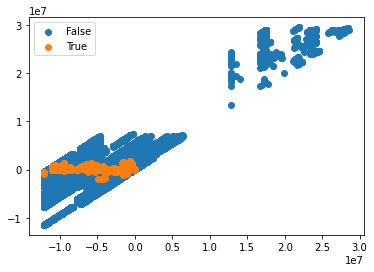

Counter({False: 5330, True: 2665})


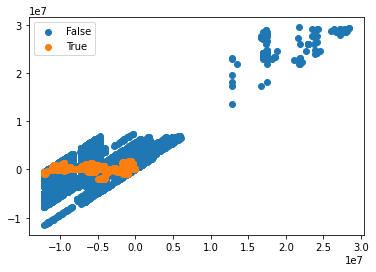

In [68]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#Visualise class distribution before rebalancing
summariseClassDistribution(modelsData_trainFeatures, 
                           modelsData_trainLabels)

# define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over),('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
modelsData_trainFeatures, modelsData_trainLabels = pipeline.fit_resample(modelsData_trainFeatures, modelsData_trainLabels)

#Visualise class distribution after rebalancing
summariseClassDistribution(modelsData_trainFeatures, 
                           modelsData_trainLabels)

## 4.3 Modeling - Random Forest (OLD, only used for quick testing)

Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall     F1        F2      F0.5  Average Precision
0  0.979562   0.333333  0.682927  0.448  0.564516  0.371353           0.231493

--------------------------------------------------------------------


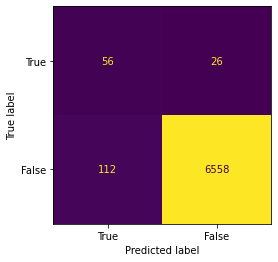

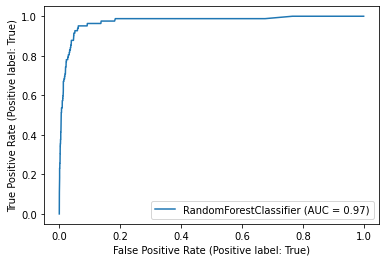

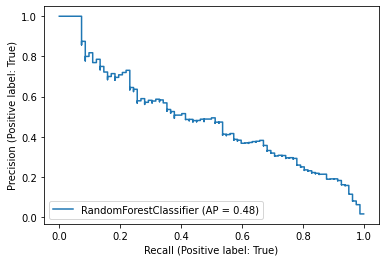

In [63]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)

# Train the model on training data
rf.fit(modelsData_trainFeatures, modelsData_trainLabels.astype(bool));

#Display the model performance    
showModelPerformance(trainedModel = rf, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)


Elapsed time to compute the importances: 0.165 seconds


<ipython-input-69-ba07509e8bc7>:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


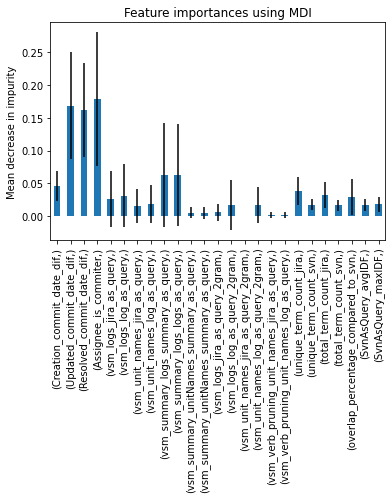

In [69]:
import time
import numpy as np

start_time = time.time()
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

import pandas as pd
import matplotlib.pyplot as plt
forest_importances = pd.Series(importances, index=[processedData_dataProcessingFeatureNames])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 4.4 Modeling - XGBoost (OLD, only used for quick testing)

C:\Users\rande\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:18:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2  F0.5  Average Precision
0  0.983709   0.462025  0.744898  0.570312  0.663636   0.5           0.347864

--------------------------------------------------------------------


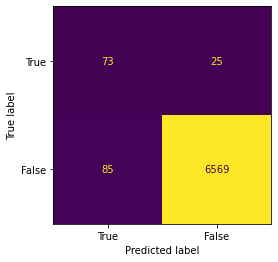

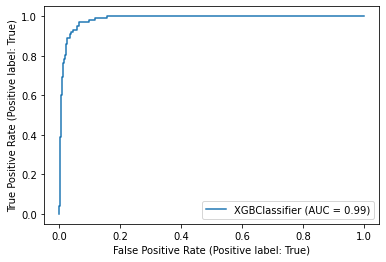

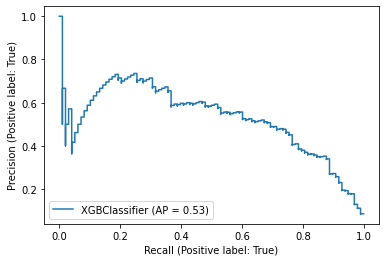

In [70]:
import xgboost as xgb

# Instantiate xgboost
GXBoost = xgb.XGBClassifier(#scale_pos_weight=1,
                            learning_rate=0.17,
                            colsample_bytree = 0.4,
                            subsample = 1.0,
                            objective='binary:logistic',
                            n_estimators=750,
                            max_depth=12,
                            gamma=0.03,
                            n_jobs=-1
                           # seed=27
)



# Train the model on training data
GXBoost.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = GXBoost, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)

# Model Pipeline - Light GBM

Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2  F0.5  Average Precision
0   0.98356   0.460123  0.765306  0.574713  0.675676   0.5           0.355541

--------------------------------------------------------------------


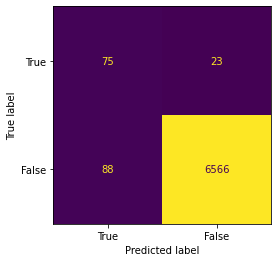

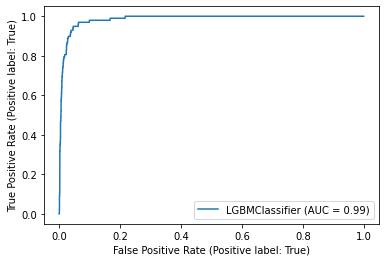

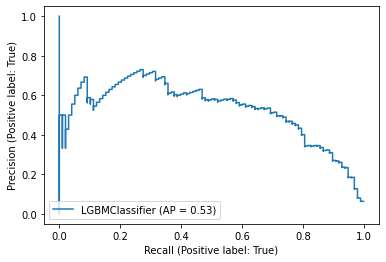

In [71]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Import the model we are using
import lightgbm as lgb

# Instantiate Light GBM
LightGBM_Model = lgb.LGBMClassifier( n_jobs=-1, n_estimators = 500, max_depth = 9)                         

# Train the model on training data
LightGBM_Model.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = LightGBM_Model, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)

# Model - Pipeline for GXBoost

In [72]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb


start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


GXBoostPipeline = Pipeline(steps = [['smote', SMOTE(sampling_strategy = 0.1, n_jobs=-1)],
                                    ['under', RandomUnderSampler()],
                                ['classifier', xgb.XGBClassifier(n_jobs=-1)]])

stratified_kfold = StratifiedKFold(n_splits=3,shuffle=True)

# define search space
space = dict()
space['classifier__n_estimators'] = [450, 500, 550, 600, 650, 700, 750, 800, 850, 900]
space['classifier__max_depth'] = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
space['classifier__subsample'] = [0.7, 0.8, 0.9, 1.0]
space['classifier__learning_rate'] = [0.17, 0.18, 0.19, 0.2]
space['classifier__colsample_bytree'] = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
space['classifier__gamma'] = [0.01, 0.02, 0.03, 0.04, 0.05]

GXBoostSearch = RandomizedSearchCV(estimator = GXBoostPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring='recall', 
                            n_jobs=-1, 
                            cv = stratified_kfold)

optimizedGXBoostModel = GXBoostSearch.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

KeyboardInterrupt: 

In [ ]:
cv_score = optimizedGXBoostModel.best_score_
test_score = optimizedGXBoostModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedGXBoostModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedGXBoostModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

# Model - Pipeline for Light GBM

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Import feature selection stuff
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

# Import the model we are using
import lightgbm as lgb


start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.25,
                                                    stratify=labels)


LightGBMPipeline = Pipeline(steps = [['smote', SMOTE(sampling_strategy = 0.1, n_jobs=-1)],
                                    ['under', RandomUnderSampler(sampling_strategy = 0.5)],
                                ['classifier', lgb.LGBMClassifier(n_jobs=-1)]])

stratified_kfold = StratifiedKFold(n_splits=3,shuffle=True)

# define search space
space = dict()
space['classifier__num_leaves'] = [60, 70, 80, 90, 100]
space['classifier__max_depth'] = [5, 6, 7, 8]
space['classifier__min_data_in_leaf'] = [250, 500, 750, 1000, 1250, 1500]


LightGBMSearch = RandomizedSearchCV(estimator = LightGBMPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=-1, 
                            cv = stratified_kfold)

optimizedLightGBMModel = LightGBMSearch.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
cv_score = optimizedLightGBMModel.best_score_
test_score = optimizedLightGBMModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedLightGBMModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedLightGBMModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)